# GZTAN PROJECT

# Reuisng our code for the proof of concept, for a different dataset called GZTAN

The GTZAN dataset is a widely used dataset for music genre classification. It was introduced by George Tzanetakis and Perry Cook in 2002 and consists of 1,000 audio tracks each with a duration of 30 seconds. These tracks are evenly distributed across 10 different genres, making it a balanced dataset for classification task

genres : Blues, Classic, Country, Disco, Hip-hop, Jazz, Metal, Pop, Reggae & finally Rock.

Imports 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from scipy.signal import butter, filtfilt
from scipy.fft import fft
import pywt
from PyEMD import EMD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, GRU,SimpleRNN,LSTM
from tensorflow.keras import backend as K
from datasets import Dataset, load_dataset
import IPython.display as ipd
import librosa
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

Activating GPU

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found or TensorFlow cannot access the GPU. Using CPU instead.")

GPU is available and will be used.


Loading Data:

In [8]:
dataset = load_dataset("marsyas/gtzan", trust_remote_code=True)
train_dataset = dataset["train"]
id2label = train_dataset.features["genre"].int2str
def extract_mel_spectrogram_28x28_from_audio(
    audio_array: np.ndarray,
    sampling_rate: int,
    n_mels: int = 128,
    desired_size: tuple = (28, 28)
) -> np.ndarray:

    mel_spec = librosa.feature.melspectrogram(y=audio_array, sr=sampling_rate, n_mels=n_mels, fmax=sampling_rate / 2)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    min_val = log_mel_spec.min()
    max_val = log_mel_spec.max()
    log_mel_spec_norm = (log_mel_spec - min_val) / (max_val - min_val + 1e-9)
    log_mel_spec_norm = (log_mel_spec_norm * 255).astype(np.uint8)
    image = Image.fromarray(log_mel_spec_norm)
    image = image.resize(desired_size, Image.Resampling.LANCZOS)
    return np.array(image)
X_data = []
Y_data = []
for example in train_dataset:
    audio_array = example["audio"]["array"]
    sr = example["audio"]["sampling_rate"]
    label_int = example["genre"]
    label_str = id2label(label_int)
    mel_50x50 = extract_mel_spectrogram_28x28_from_audio(audio_array, sr, n_mels=128, desired_size=(28, 28))
    X_data.append(mel_50x50)
    Y_data.append(label_int)
MEL_X = np.array(X_data)  
MEL_Y = np.array(Y_data) 
del dataset
print("X shape:", MEL_X.shape)  
print("Y shape:", MEL_Y.shape)  
print("Unique labels:", np.unique(MEL_Y))

X shape: (999, 28, 28)
Y shape: (999,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


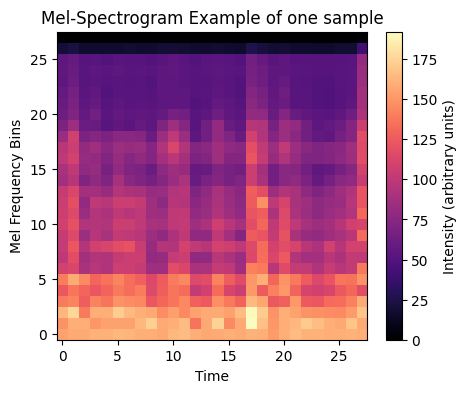

In [9]:
def plot_mel_spectrogram(mel_array, title="Mel-Spectrogram Example of one sample"):
    plt.figure(figsize=(5, 4))
    plt.imshow(mel_array, origin='lower', aspect='auto', cmap='magma')
    plt.colorbar(label='Intensity (arbitrary units)')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency Bins")
    plt.show()

plot_mel_spectrogram(MEL_X[20], title="Mel-Spectrogram Example of one sample")

Code For the experiment

In [11]:
def load_gtzan_dataset_classic(num_samples=200):
    dataset = load_dataset("marsyas/gtzan", trust_remote_code=True)
    X = []
    y = []
    for item in dataset['train']:  
        genre = item['genre']  
        audio = item['audio']['array']  
        mid_idx = len(audio) // 2
        start_idx = max(0, mid_idx - num_samples // 2)
        end_idx = start_idx + num_samples
        x_values = audio[start_idx:end_idx]
        if len(x_values) != num_samples:
            x_values = np.pad(x_values, (0, num_samples - len(x_values)), mode='constant')
        X.append(x_values)
        y.append(genre)
    X = np.array(X)
    y = np.array(y)
    return X, y



def CNNSignalExperiment(
    X, y,
    transform_options = ['raw','fourier','wavelet','emd','ALL','mel'],
    batch_size=50,
    max_epochs=10,
    plot_title="Epileptic Seizure Recognition",RUN=1
):

    def get_predictions(model, X_data):
      
        y_pred_proba = model.predict(X_data)
        if is_binary:
    
            y_pred = (y_pred_proba > 0.5).astype(int).ravel()
        else:
       
            y_pred = np.argmax(y_pred_proba, axis=1)
        return y_pred

    unique_labels = np.unique(y)
    num_classes = len(unique_labels)
    is_binary = (num_classes == 2)
  



    def butter_bandpass(lowcut, highcut, fs, order=6):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def bandpass_filter(signal_1d, lowcut=0, highcut=60, fs=22050, order=6):
        b, a = butter_bandpass(lowcut, highcut, fs, order)
        return filtfilt(b, a, signal_1d)

    X_filtered = []
    for i in range(X.shape[0]):
        seg_filt = bandpass_filter(X[i], 0.5, 60, 173.61, order=6)
        X_filtered.append(seg_filt)
    X_filtered = np.array(X_filtered)
    print("After bandpass filtering, X_filtered shape =", X_filtered.shape)
    Xbackup = X_filtered.copy() 
    

    def raw_transform(signal_1d):
        return signal_1d[np.newaxis, :] 

    def fourier_transform(signal_1d):
        fft_vals = fft(signal_1d)
        half_spectrum = np.abs(fft_vals[: len(signal_1d)//2])  
        # pad/truncate to 128
        desired_len = 128
        if len(half_spectrum) < desired_len:
            half_spectrum = np.pad(half_spectrum, (0, desired_len - len(half_spectrum)), 'constant')
        else:
            half_spectrum = half_spectrum[:desired_len]
        return half_spectrum[np.newaxis, :]

    def wavelet_transform(signal_1d):
        coeffs = pywt.wavedec(signal_1d, wavelet='db8', level=5)
        wv = np.concatenate(coeffs, axis=0)
        desired_len = 256
        if len(wv) < desired_len:
            wv = np.pad(wv, (0, desired_len - len(wv)), 'constant')
        else:
            wv = wv[:desired_len]
        return wv[np.newaxis, :]

    def emd_transform(signal_1d, n_imfs=6):
        emd = EMD()
        IMFs = emd(signal_1d)
        if IMFs.shape[0] > n_imfs:
            IMFs = IMFs[:n_imfs, :]
    
        if IMFs.shape[0] < n_imfs:
            needed = n_imfs - IMFs.shape[0]
            extra = np.zeros((needed, IMFs.shape[1]))
            IMFs = np.vstack((IMFs, extra))
        return IMFs  

    def prepare_input_2d(signal_1d, transform='raw'):
        if transform == 'raw':
            return raw_transform(signal_1d)

        elif transform == 'fourier':
            return fourier_transform(signal_1d)

        elif transform == 'wavelet':
            return wavelet_transform(signal_1d)

        elif transform == 'emd':
            return emd_transform(signal_1d, n_imfs=6)

        elif transform == 'ALL':
   
            raw_ = raw_transform(signal_1d)
            if raw_.shape[1] < 256:
                raw_ = np.pad(raw_, ((0,0),(0,256-raw_.shape[1])), 'constant')
            else:
                raw_ = raw_[:, :256]

          
            four_ = fourier_transform(signal_1d)
            if four_.shape[1] < 256:
                four_ = np.pad(four_, ((0,0),(0,256-four_.shape[1])), 'constant')
            else:
                four_ = four_[:, :256]

           
            wave_ = wavelet_transform(signal_1d)

         
            emd_ = emd_transform(signal_1d, 6)
            if emd_.shape[1] < 256:
                emd_ = np.pad(emd_, ((0,0),(0,256-emd_.shape[1])), 'constant')
            else:
                emd_ = emd_[:, :256]

            return np.concatenate([raw_, four_, wave_, emd_], axis=0)

        else:
            raise ValueError("Unknown transform: " + transform)

    def transform_dataset(X_array, transform='raw'):
        out_list = []
        for seg in X_array:
            feats_2d = prepare_input_2d(seg, transform)
            
            feats_3d = feats_2d[..., np.newaxis]
            out_list.append(feats_3d)
        return np.array(out_list)



    def build_cnn_model(input_shape):
        model = Sequential()
        model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(1,3), padding='valid'))
        model.add(Dropout(0.2))
        model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        if is_binary:
           
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        else:
      
            model.add(Dense(num_classes, activation='softmax'))
            model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        return model


   
    def train_select_best_epoch(X_train, y_train, X_val, y_val):
       
        model_temp = build_cnn_model(input_shape=X_train.shape[1:])
        best_epoch = 0
        best_val_acc = 0.0

        for epoch in range(1, max_epochs+1):
            model_temp.fit(X_train, y_train, batch_size=batch_size, epochs=1, verbose=0)
            val_loss, val_acc = model_temp.evaluate(X_val, y_val, verbose=0)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch

        K.clear_session()
        return best_epoch, best_val_acc

    def retrain_and_test(X_trainval, y_trainval, X_test, y_test, best_epoch):
        model_final = build_cnn_model(input_shape=X_trainval.shape[1:])
        model_final.fit(X_trainval, y_trainval, batch_size=batch_size, epochs=best_epoch, verbose=0)
        test_loss, test_acc = model_final.evaluate(X_test, y_test, verbose=0)
        K.clear_session()
        return model_final,test_acc


    def get_fold_assignments(n_folds=5, X_data=None, y_data=None, random_state=42):
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
        all_folds = []
        for _, idx in enumerate(skf.split(X_data, y_data)):
            all_folds.append(idx)

        test_folds = [all_folds[i][1] for i in range(n_folds)]
        all_indices = np.arange(X_data.shape[0])
        fold_assignments = []
        for i in range(n_folds):
            test_idx = test_folds[i]
            val_idx  = test_folds[(i+1) % n_folds]
            test_val_union = np.union1d(test_idx, val_idx)
            train_idx = np.setdiff1d(all_indices, test_val_union)
            fold_assignments.append((train_idx, val_idx, test_idx))
        return fold_assignments

  
    n_repeats = 3


    results = {t: None for t in transform_options}
    results_std = {t: None for t in transform_options}
    confusion_data = {t: {'y_true': [], 'y_pred': []} for t in transform_options}
    fold_assignments = get_fold_assignments(n_folds=5, X_data=X_filtered, y_data=y, random_state=RUN)

 
    for transform in transform_options:
        print(f"\n=== Transform: {transform} ===")
        fold_acc_list = []

        for i, (train_idx, val_idx, test_idx) in enumerate(fold_assignments):
            print(f" Fold {i+1} => train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")
            if transform == 'mel':
                X_filtered = MEL_X[...,np.newaxis].copy()
            else:
                X_filtered = Xbackup.copy()
            print (X_filtered.shape)
          
            X_tr_raw = X_filtered[train_idx]
            y_tr     = y[train_idx]
            X_val_raw= X_filtered[val_idx]
            y_val    = y[val_idx]
            X_test_raw= X_filtered[test_idx]
            y_test   = y[test_idx]

           
            if transform != 'mel':
                X_train_tf = transform_dataset(X_tr_raw, transform=transform)
                X_val_tf   = transform_dataset(X_val_raw, transform=transform)
                X_test_tf  = transform_dataset(X_test_raw, transform=transform)
            else:
                X_train_tf = X_tr_raw.copy()
                X_val_tf   = X_val_raw.copy()
                X_test_tf  = X_test_raw.copy()
            repeat_accs = []
            for rep in range(n_repeats):
                best_epoch, best_val_acc = train_select_best_epoch(
                    X_train_tf, y_tr,
                    X_val_tf, y_val
                )

              
                X_trainval_tf = np.concatenate([X_train_tf, X_val_tf], axis=0)
                y_trainval    = np.concatenate([y_tr, y_val], axis=0)
                final_model, test_acc = retrain_and_test(
                    X_trainval_tf, y_trainval,
                    X_test_tf, y_test,
                    best_epoch
                )
                repeat_accs.append(test_acc)
                

                
                y_pred = get_predictions(final_model, X_test_tf)

               
                confusion_data[transform]['y_true'].extend(y_test)
                confusion_data[transform]['y_pred'].extend(y_pred)
                

            mean_test_acc = np.mean(repeat_accs)
            fold_acc_list.append(mean_test_acc)
            print(f" => Fold {i+1} average test_acc over repeats: {mean_test_acc:.4f}")

    
        overall_mean = np.mean(fold_acc_list)
        overall_std  = np.std(fold_acc_list)
        results[transform]     = overall_mean
        results_std[transform] = overall_std

        print(f"\nTransform [{transform}] => 5-fold mean={overall_mean:.4f}, std={overall_std:.4f}")


    print("\n===== FINAL RESULTS =====")
    for t in transform_options:
        print(f"{t:>8s} => mean={results[t]:.4f}, std={results_std[t]:.4f}")


    for transform in transform_options:
        all_y_true = confusion_data[transform]['y_true']
        all_y_pred = confusion_data[transform]['y_pred']

     
        cm = confusion_matrix(all_y_true, all_y_pred, labels=unique_labels,normalize='true')
        disp = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(ax=ax, cmap="Blues", colorbar=False)
        plt.title(f"Confusion Matrix - Transform={transform}")
        plt.xticks(rotation=45)
        plt.tight_layout()


      
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            all_y_true, all_y_pred, 
            labels=unique_labels,  
            average='macro'
        )
        print(f"{transform} => Macro-Avg Precision: {macro_p:.3f}, Recall: {macro_r:.3f}, F1: {macro_f1:.3f}")



    def plot_errorbar_means(results, results_std, plot_title=""):
        transforms = list(results.keys())
        means = [results[t] for t in transforms]
        stds  = [results_std[t] for t in transforms]
        x_positions = np.arange(len(transforms))
        min_means = np.min(means)
        max_stds = np.max(stds)
        plt.figure(figsize=(8,6))
        plt.errorbar(
            x_positions, means,
            yerr=stds,
            fmt='o',
            ecolor='black',
            capsize=5,
            markersize=2,
            color='blue'
        )
        plt.xticks(x_positions, transforms)
        plt.ylabel("Accuracy")
        plt.title(plot_title)
        plt.ylim([min_means - 1.125*max_stds, 1.05]) 
        for y in np.arange(0, 1.05, 0.05):
            plt.axhline(y=y, color='gray', linestyle='--', alpha=0.5)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
    
    plot_errorbar_means(results, results_std, plot_title=plot_title)
    

    return results, results_std

# How to read the values of the GZTAN dataset

Explain the labels here: 0 1 2 3 4 5 6 7 8 9?

# Multiclass classification:

Preparing the data:

In [16]:
Xgt,Ygt = load_gtzan_dataset_classic(num_samples=200)

# Run 1

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 1 average test_acc over repeats: 0.2133
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 2 average test_acc over repeats: 0.2100
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 3 average test_acc over repeats: 0.2200
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.1917
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 5 average test_acc over repeats: 0.1993

Transform [raw] => 5-fold mean=0.2069, std=0.0101

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

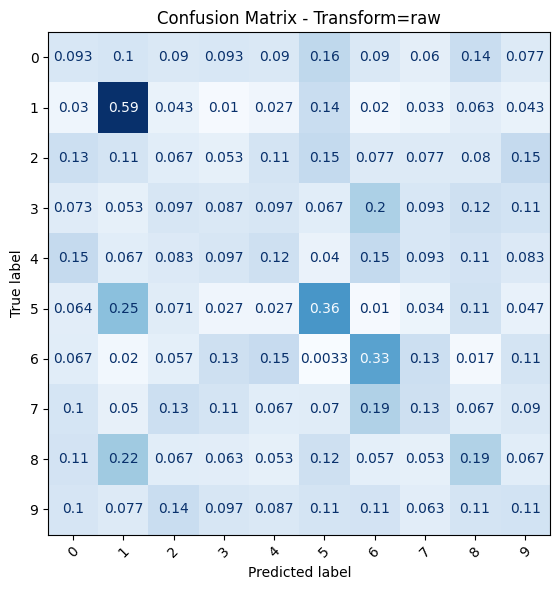

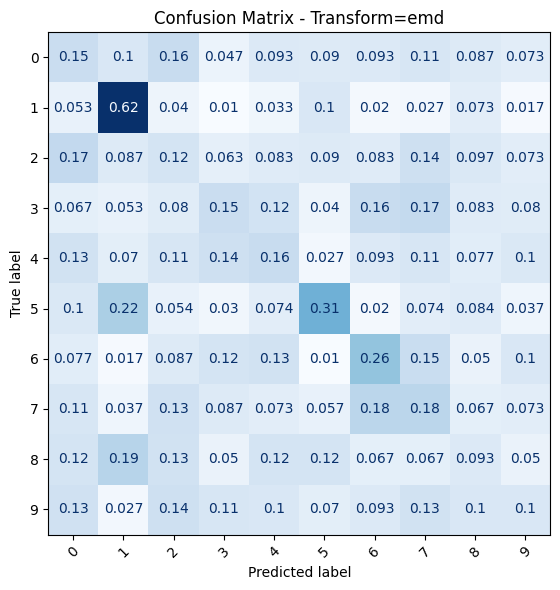

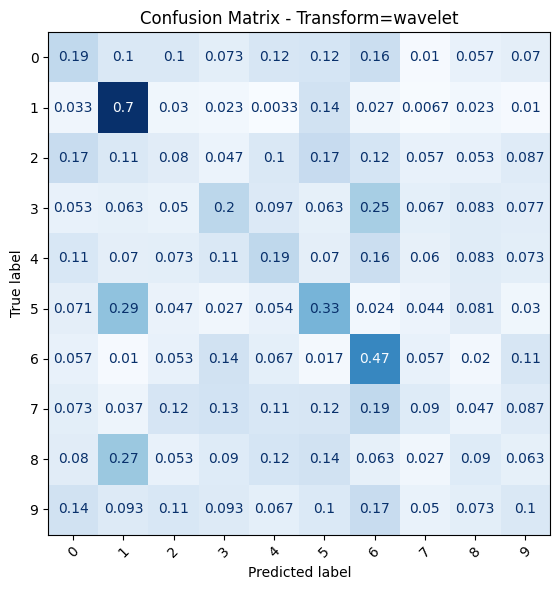

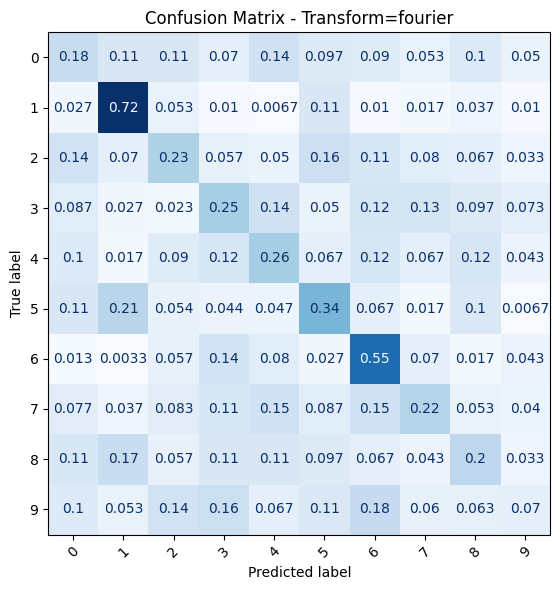

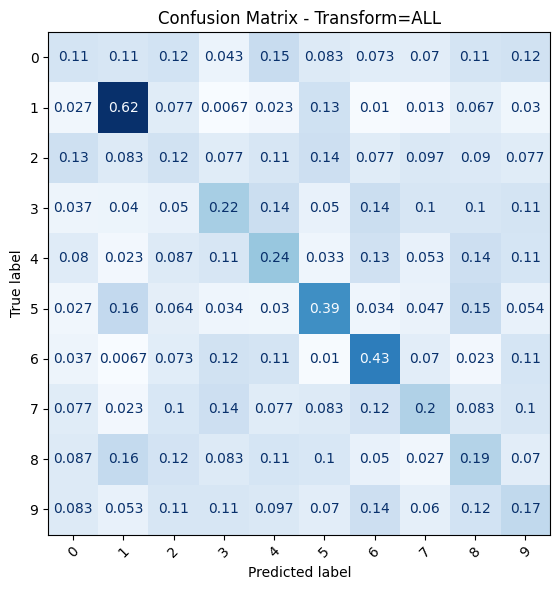

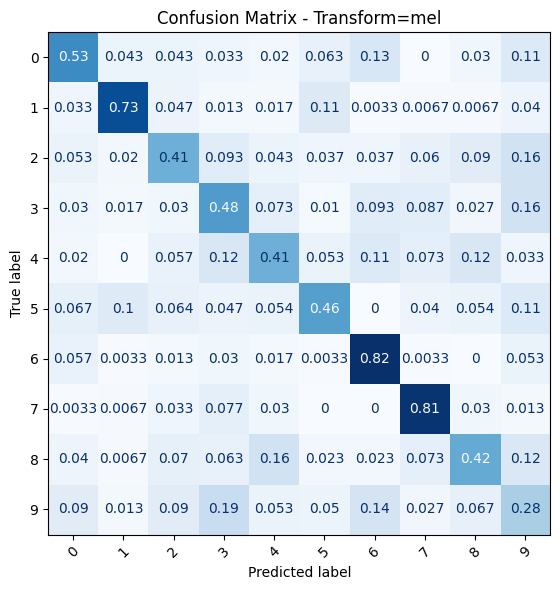

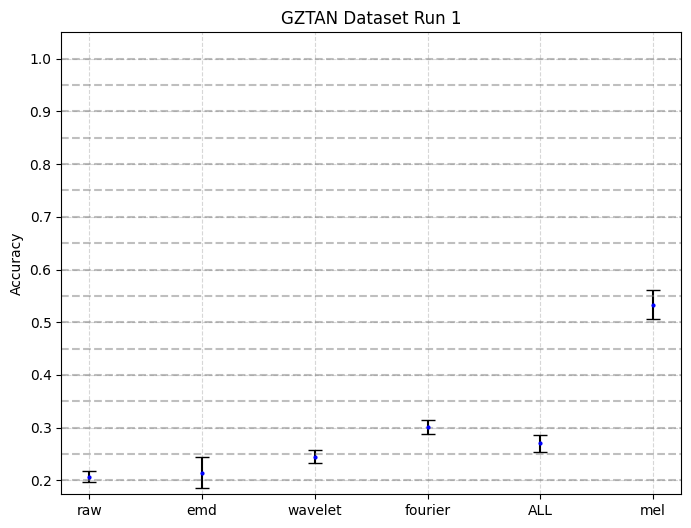

({'raw': 0.2068659951289495,
  'emd': 0.2142093787590663,
  'wavelet': 0.24493467013041176,
  'fourier': 0.3013165811697642,
  'ALL': 0.2699463983376821,
  'mel': 0.5335577885309855},
 {'raw': 0.010118909946943856,
  'emd': 0.029563906208324425,
  'wavelet': 0.012304994118758203,
  'fourier': 0.013035795209288919,
  'ALL': 0.015707235137366535,
  'mel': 0.027540048866277846})

In [18]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 1",RUN=1)

# Run 2

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 1 average test_acc over repeats: 0.2000
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 2 average test_acc over repeats: 0.1933
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 3 average test_acc over repeats: 0.1950
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 4ms/step
 => Fold 4 average test_acc over repeats: 0.2117
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 5 average test_acc over repeats: 0.2312

Transform [raw] => 5-fold mean=0.2062, std=0.0140

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

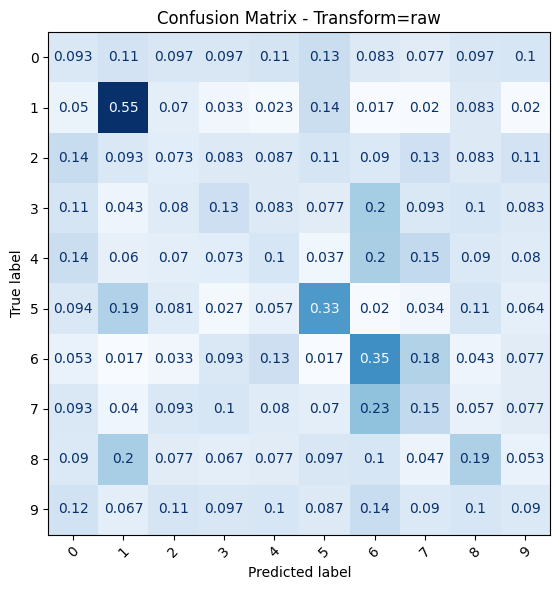

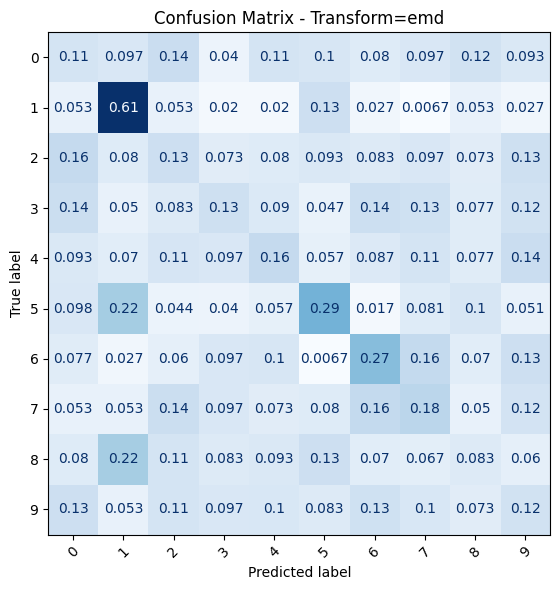

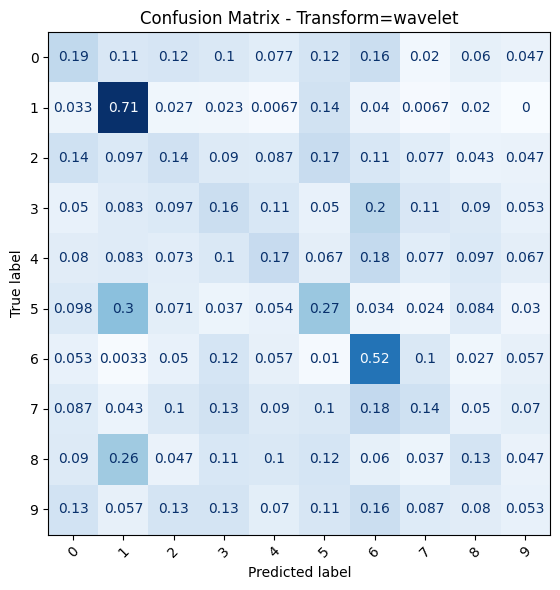

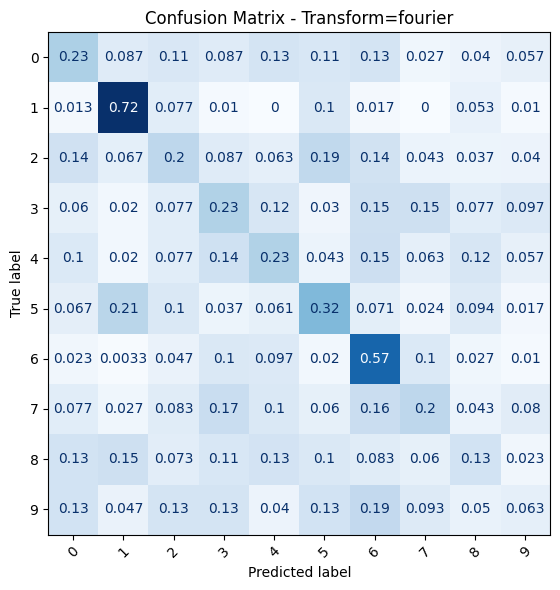

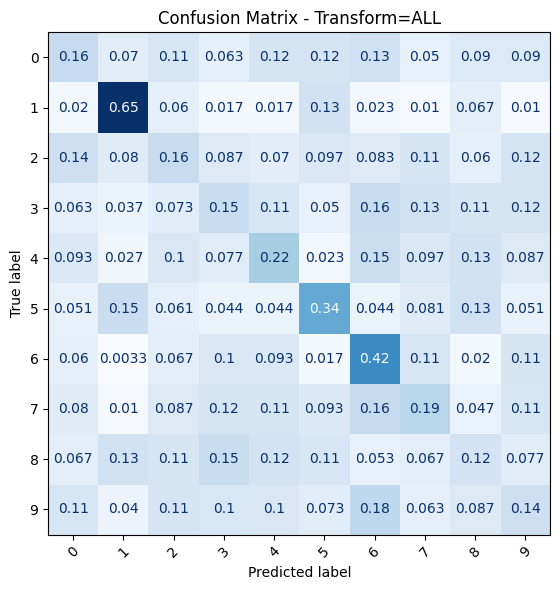

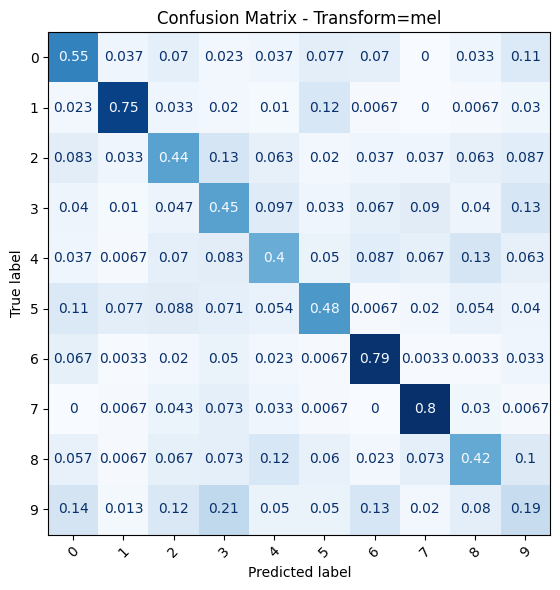

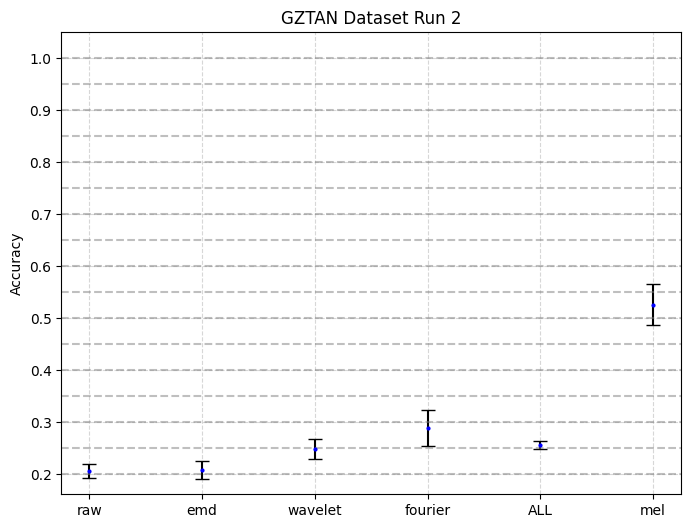

({'raw': 0.20623115599155425,
  'emd': 0.20821608106295267,
  'wavelet': 0.24827302893002826,
  'fourier': 0.2883450557788213,
  'ALL': 0.25591792066891983,
  'mel': 0.5262328346570333},
 {'raw': 0.014015004438367286,
  'emd': 0.017457590603414064,
  'wavelet': 0.018448112373850127,
  'fourier': 0.03406197547934101,
  'ALL': 0.007836132318125107,
  'mel': 0.040015827975728675})

In [20]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 2",RUN=2)

# Run 3

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 4ms/step
 => Fold 1 average test_acc over repeats: 0.2317
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 2 average test_acc over repeats: 0.1883
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 3 average test_acc over repeats: 0.2117
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.1733
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 5 average test_acc over repeats: 0.2010

Transform [raw] => 5-fold mean=0.2012, std=0.0199

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

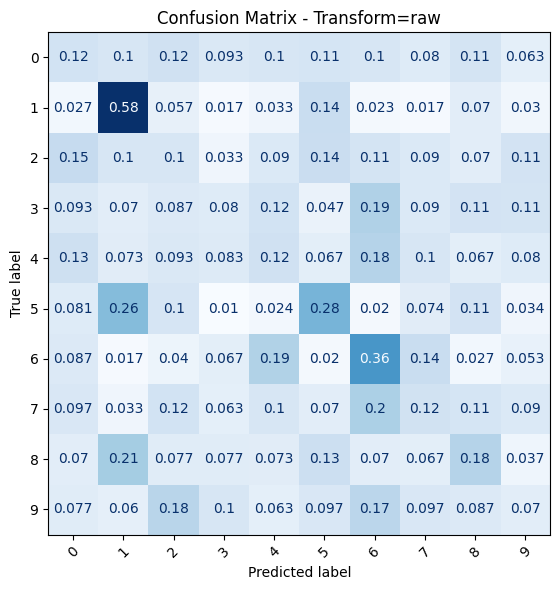

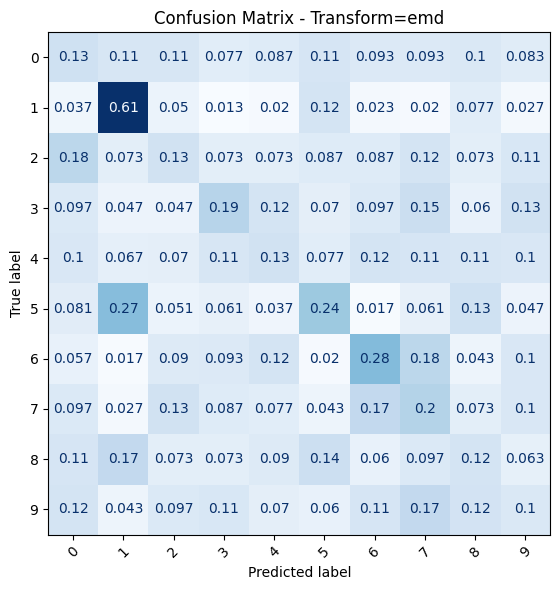

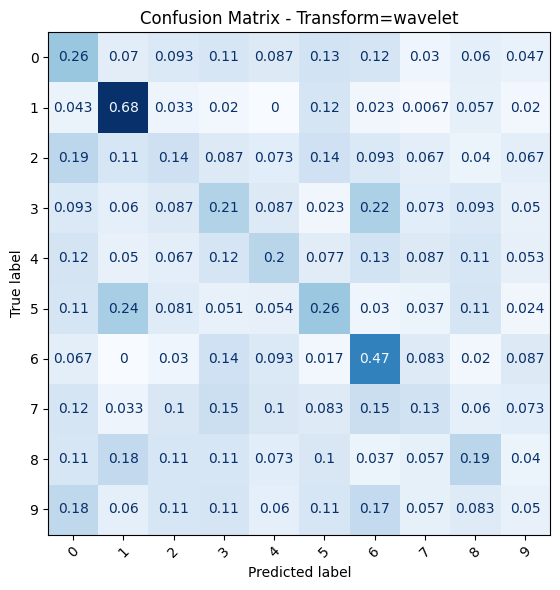

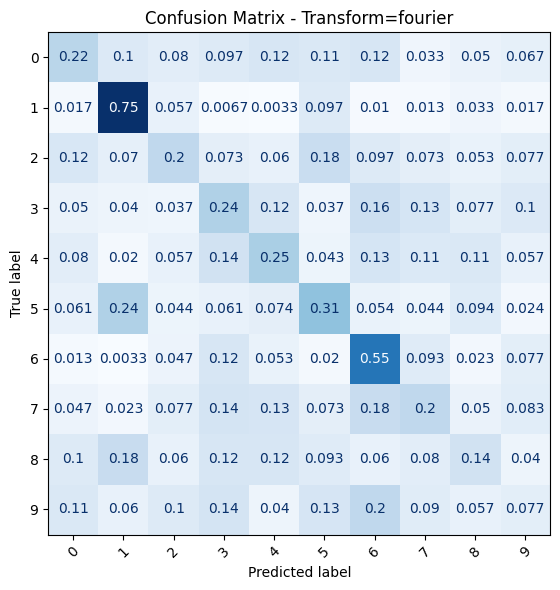

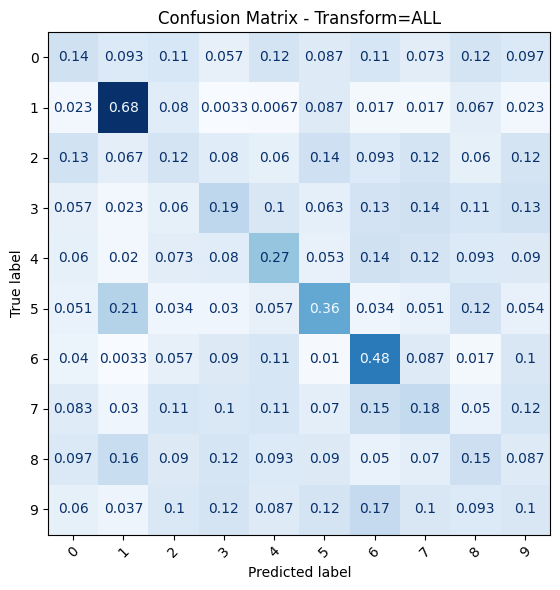

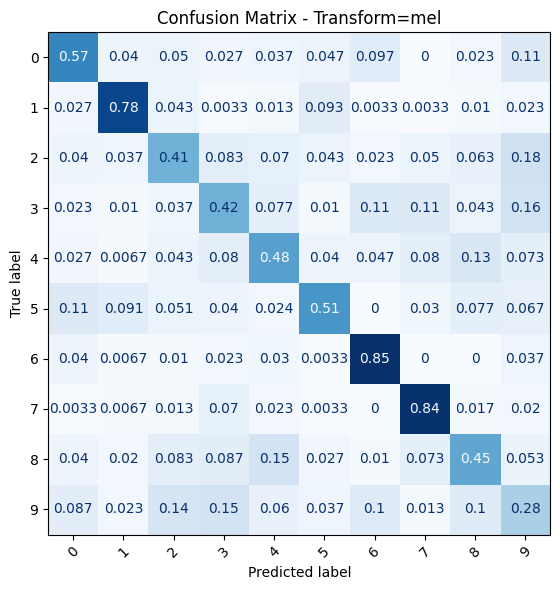

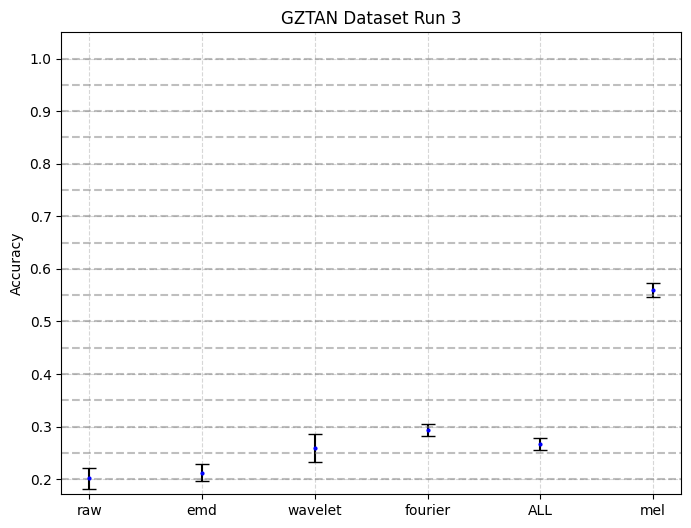

({'raw': 0.201201002796491,
  'emd': 0.21188944776852928,
  'wavelet': 0.25891289710998533,
  'fourier': 0.2936264634132385,
  'ALL': 0.2659179210662842,
  'mel': 0.559886093934377},
 {'raw': 0.019899291488645353,
  'emd': 0.01595788648153171,
  'wavelet': 0.02671996824744245,
  'fourier': 0.01107699911041912,
  'ALL': 0.011340282546632878,
  'mel': 0.012711040640206258})

In [22]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 3",RUN=3)

# Run 4

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 1 average test_acc over repeats: 0.1983
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 2 average test_acc over repeats: 0.1967
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 3 average test_acc over repeats: 0.2067
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.2150
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 5 average test_acc over repeats: 0.1993

Transform [raw] => 5-fold mean=0.2032, std=0.0068

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

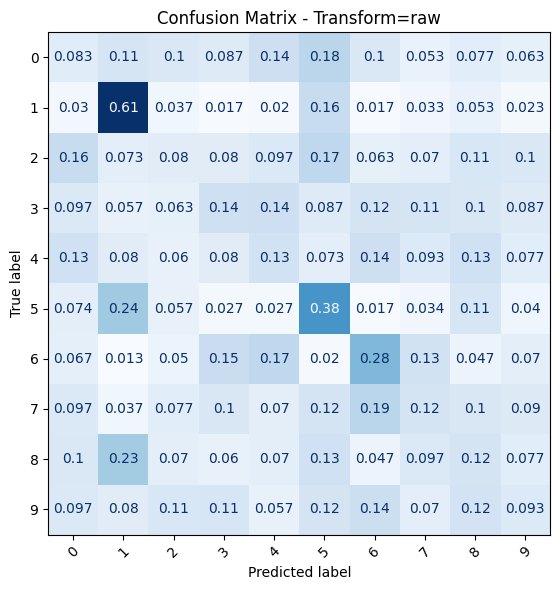

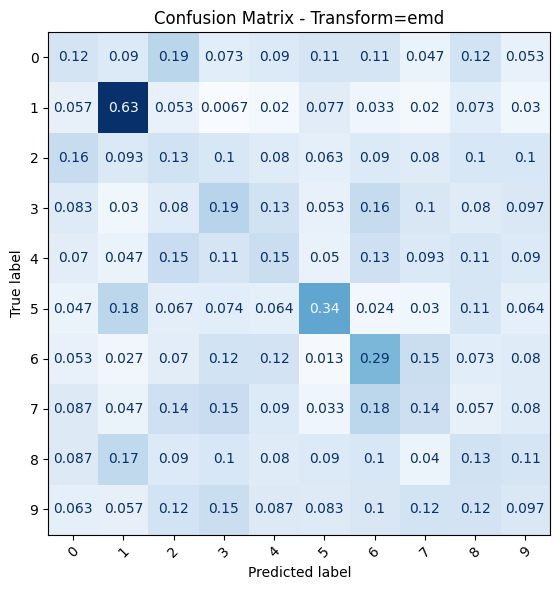

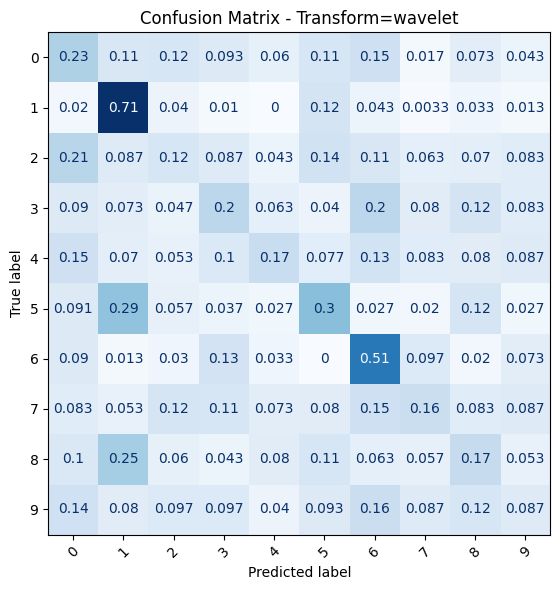

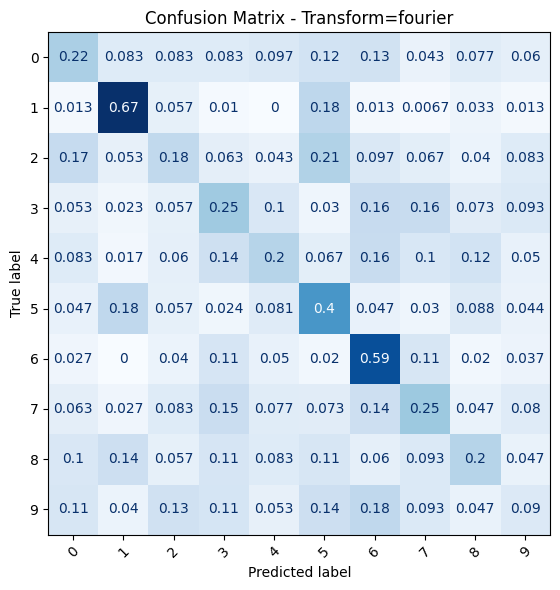

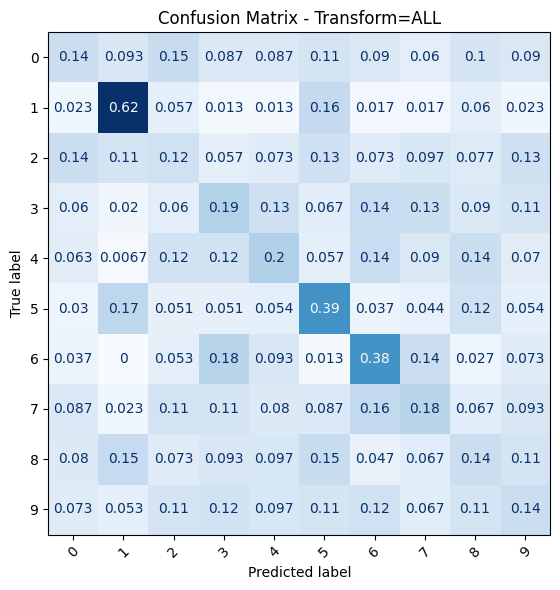

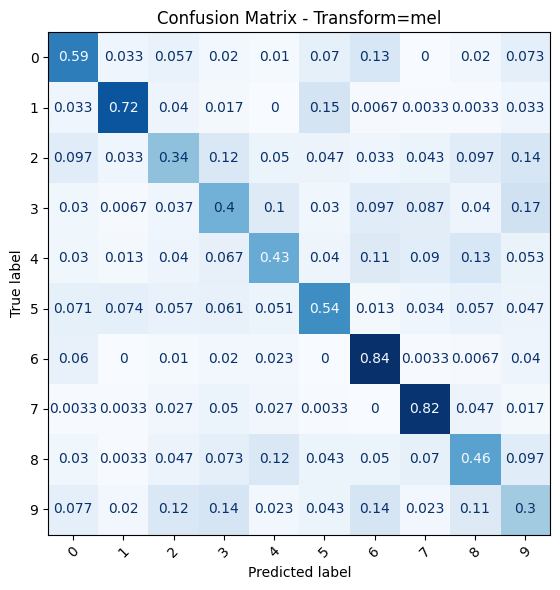

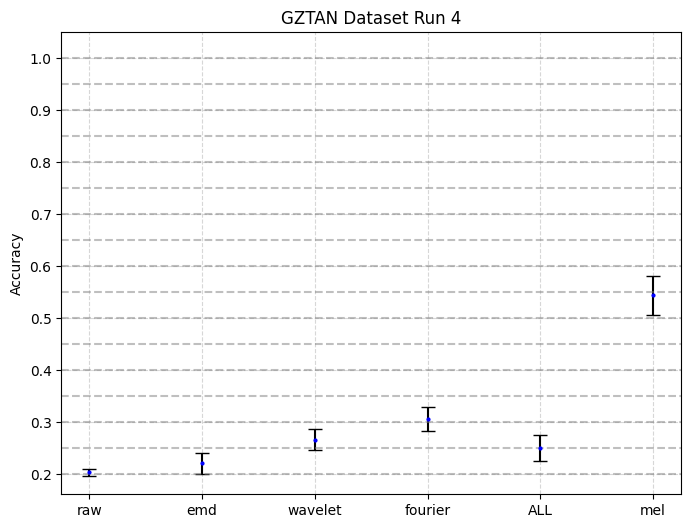

({'raw': 0.20319932897885637,
  'emd': 0.22055778900782266,
  'wavelet': 0.2659011691808701,
  'fourier': 0.3053165853023529,
  'ALL': 0.24956783652305603,
  'mel': 0.5438576261202495},
 {'raw': 0.006820610445240469,
  'emd': 0.019966455930965948,
  'wavelet': 0.020525046282896246,
  'fourier': 0.023071373909098,
  'ALL': 0.02503428979298717,
  'mel': 0.03742463586314447})

In [24]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 4",RUN=4)

# Run 5

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 1 average test_acc over repeats: 0.2150
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 2 average test_acc over repeats: 0.2067
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 3 average test_acc over repeats: 0.2267
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.1950
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 5 average test_acc over repeats: 0.1776

Transform [raw] => 5-fold mean=0.2042, std=0.0169

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

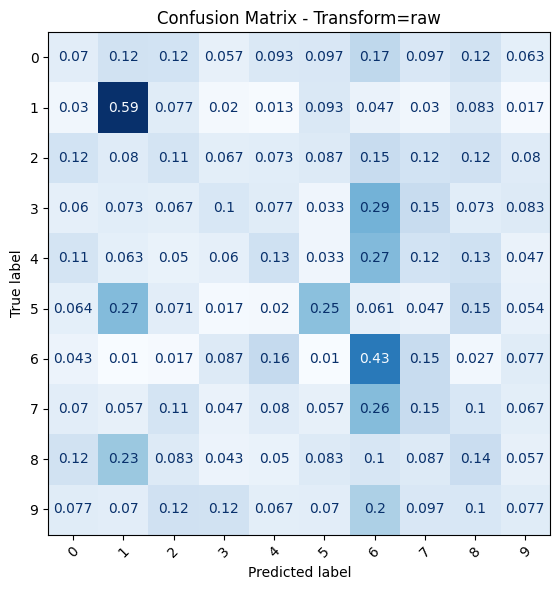

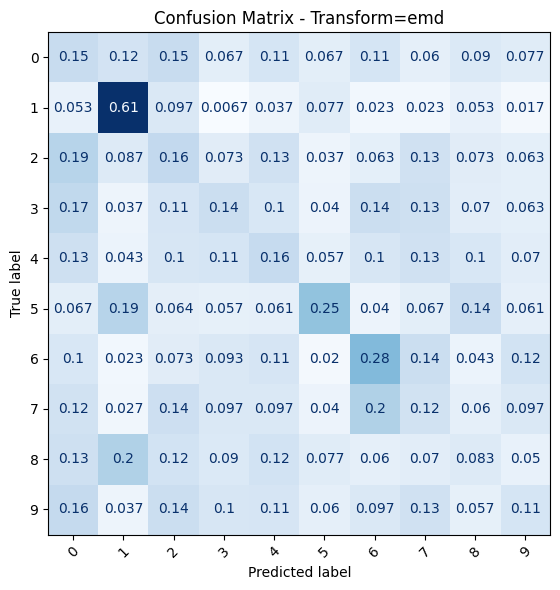

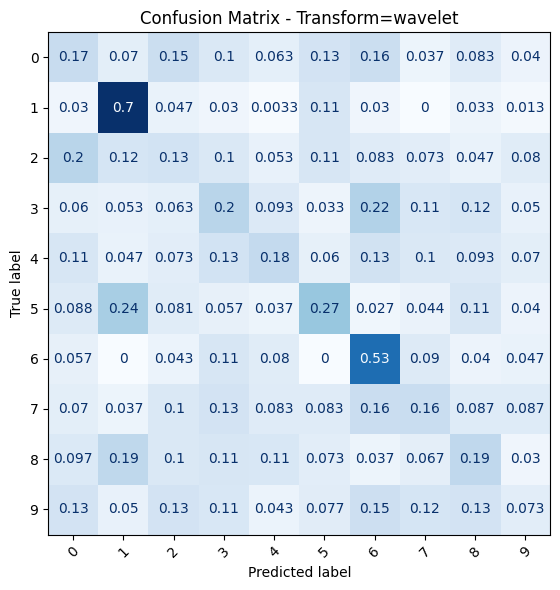

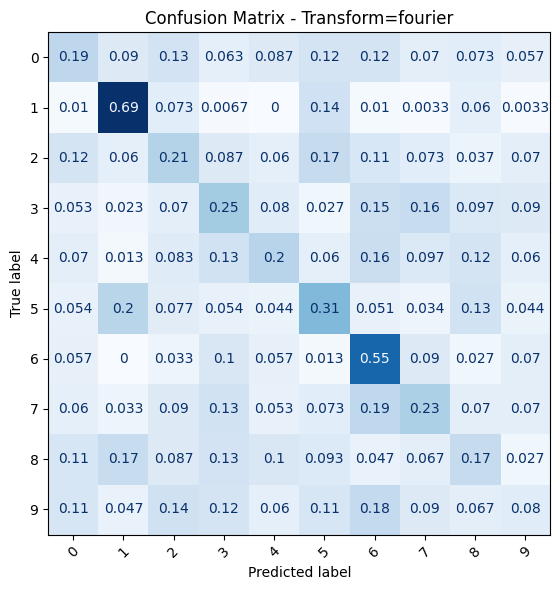

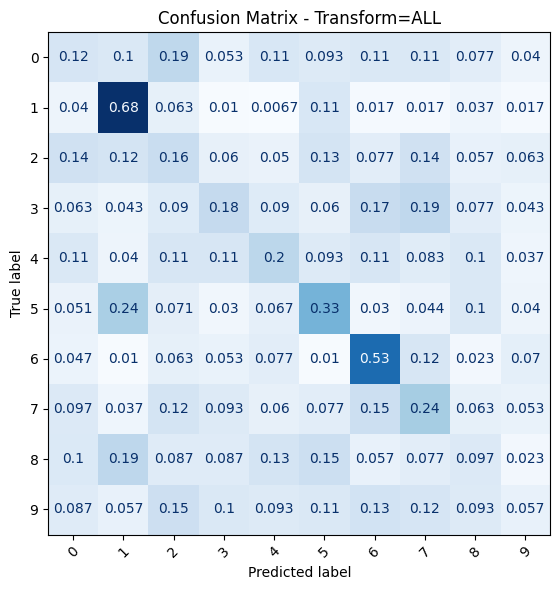

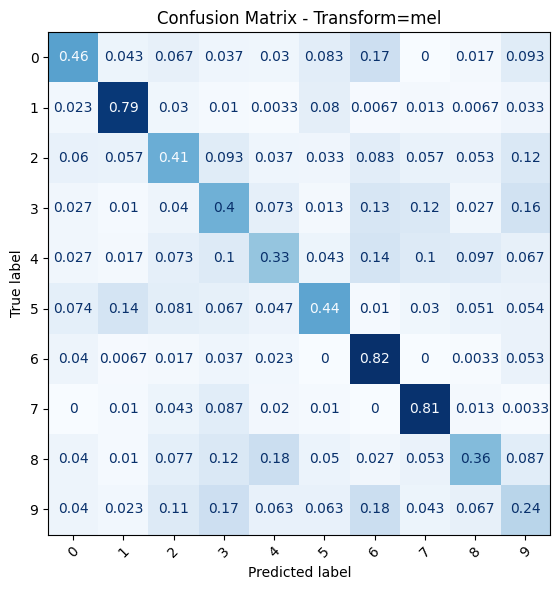

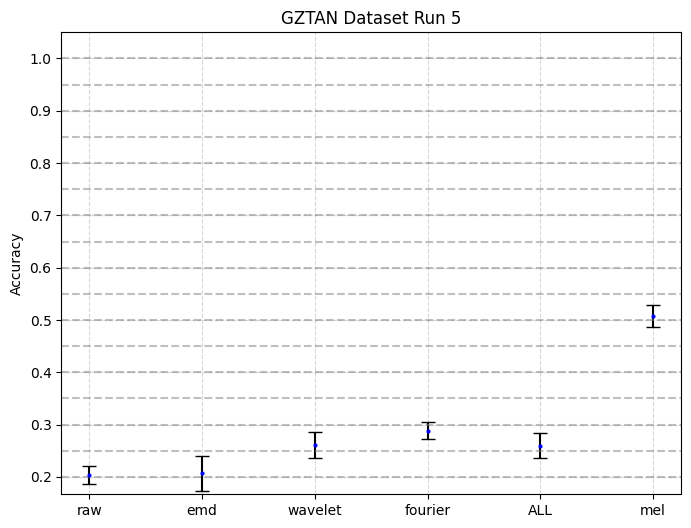

({'raw': 0.20417755345503488,
  'emd': 0.20714740256468459,
  'wavelet': 0.26088274617989854,
  'fourier': 0.2886231144269307,
  'ALL': 0.2592278083165486,
  'mel': 0.5068509221076966},
 {'raw': 0.016864750568078766,
  'emd': 0.033274448631219096,
  'wavelet': 0.024743265576093028,
  'fourier': 0.01657650364547755,
  'ALL': 0.02395664214568569,
  'mel': 0.021040673646863652})

In [26]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 5",RUN=5)

# Run 6

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 1 average test_acc over repeats: 0.1917
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 2 average test_acc over repeats: 0.1800
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 3 average test_acc over repeats: 0.1800
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.2167
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 5 average test_acc over repeats: 0.2094

Transform [raw] => 5-fold mean=0.1955, std=0.0151

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

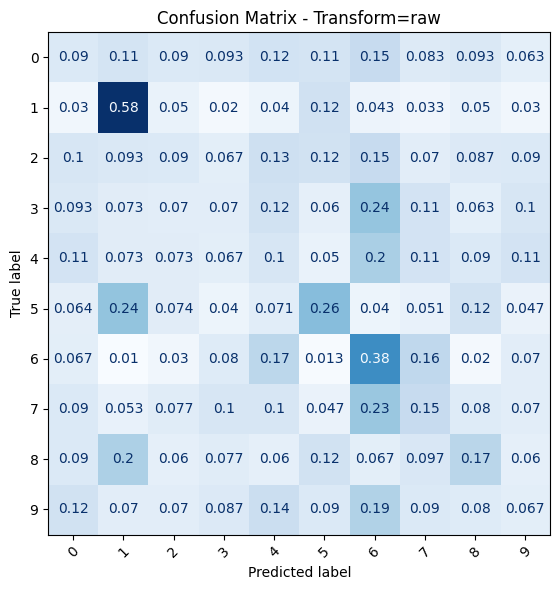

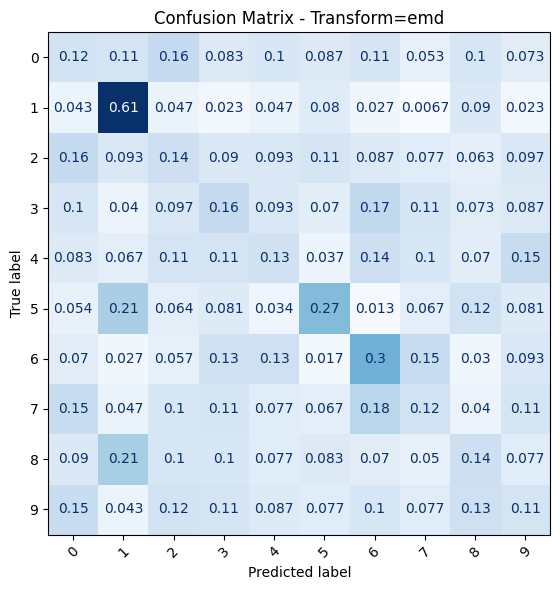

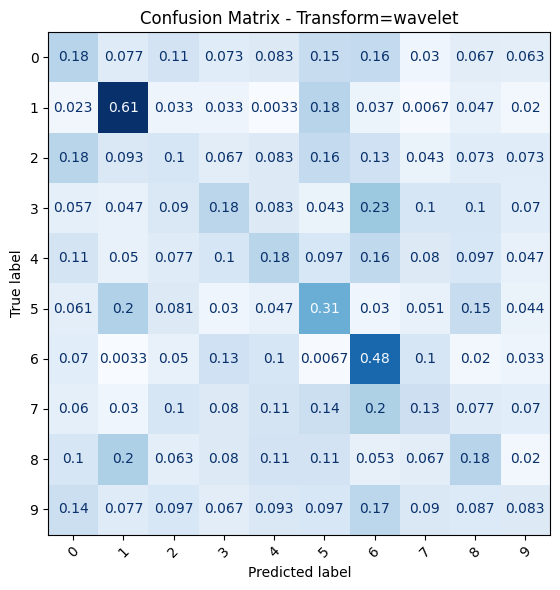

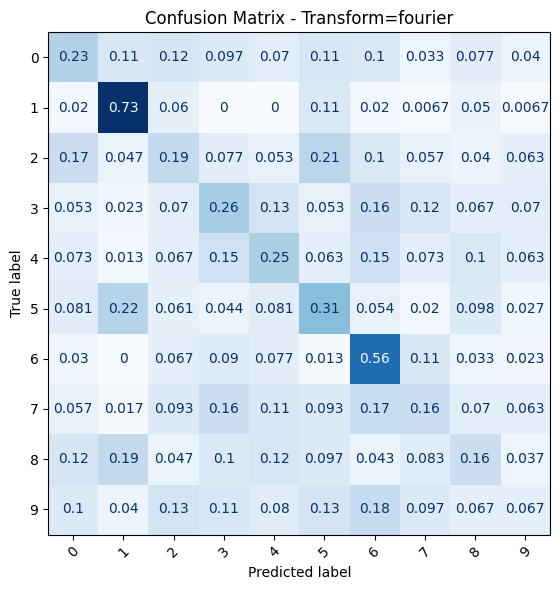

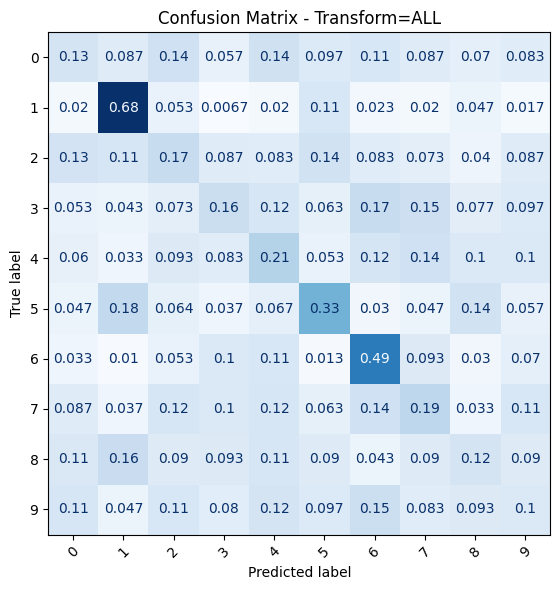

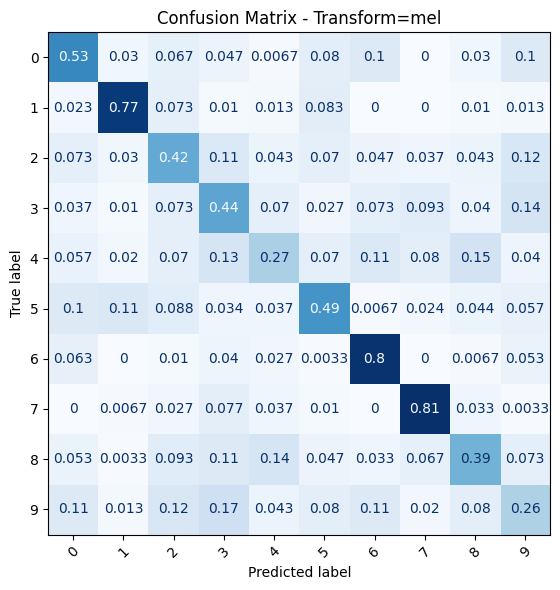

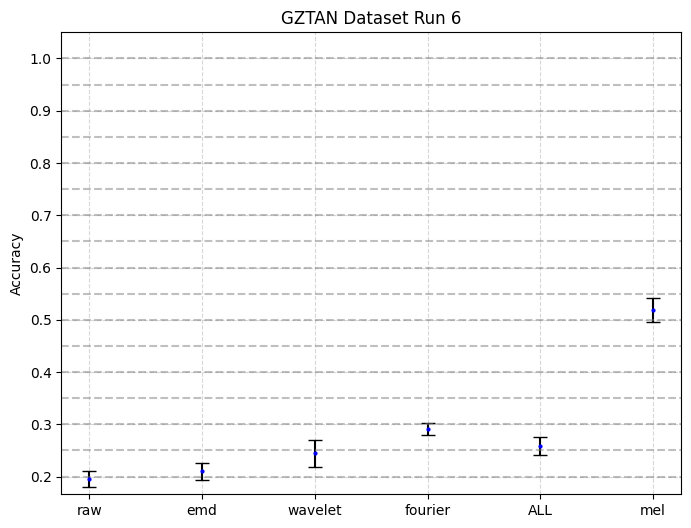

({'raw': 0.1955427139997482,
  'emd': 0.21018760204315184,
  'wavelet': 0.24460971355438232,
  'fourier': 0.2916432102521261,
  'ALL': 0.25792294740676874,
  'mel': 0.5178626517454783},
 {'raw': 0.015072317235345337,
  'emd': 0.016440036260033007,
  'wavelet': 0.026036968189946327,
  'fourier': 0.011605941520903806,
  'ALL': 0.017114200692205754,
  'mel': 0.022912902186673686})

In [28]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'],
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 6",RUN=6)

# Run 7

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 1 average test_acc over repeats: 0.1683
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 2 average test_acc over repeats: 0.1917
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 3 average test_acc over repeats: 0.2233
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.2100
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 5 average test_acc over repeats: 0.2194

Transform [raw] => 5-fold mean=0.2026, std=0.0203

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

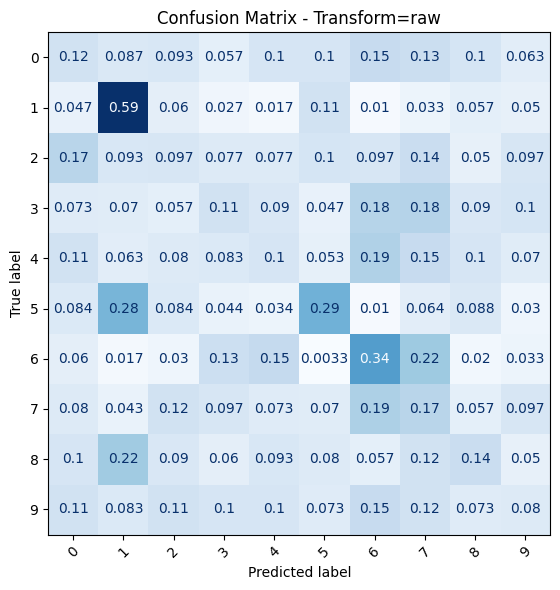

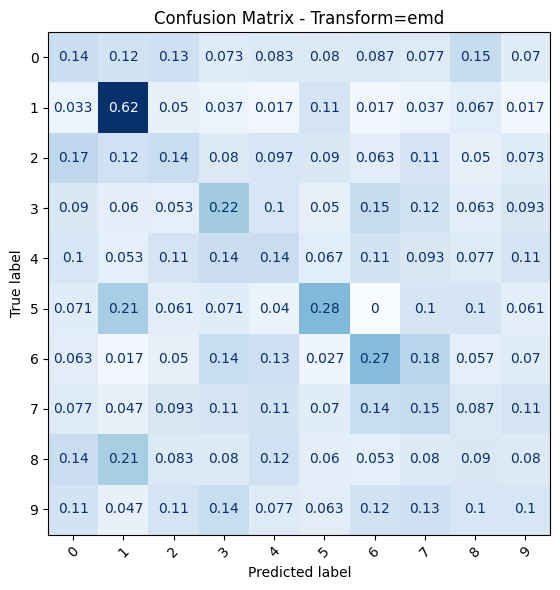

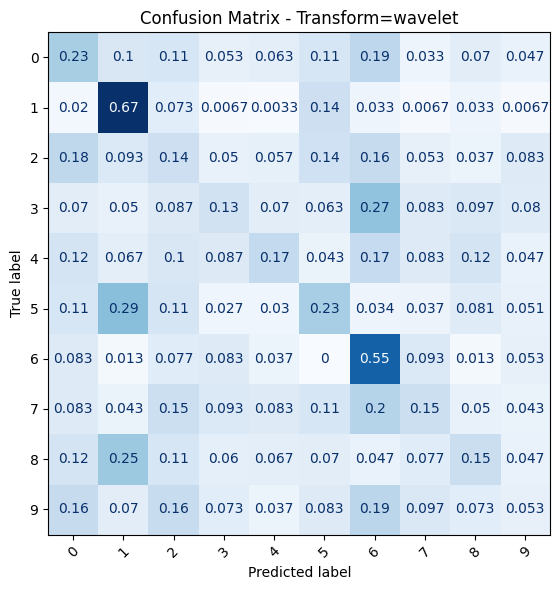

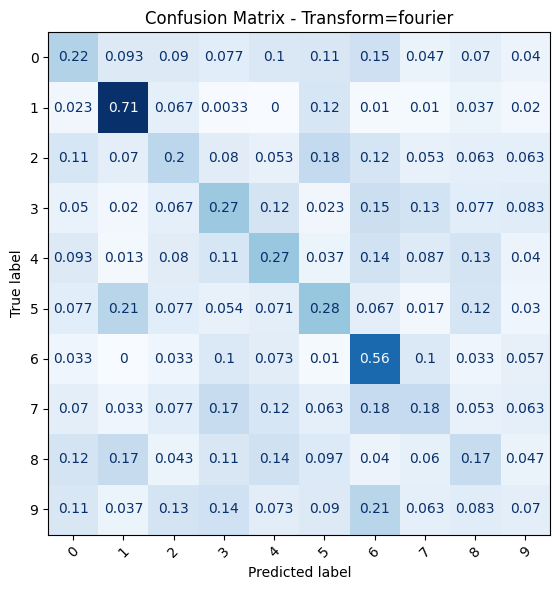

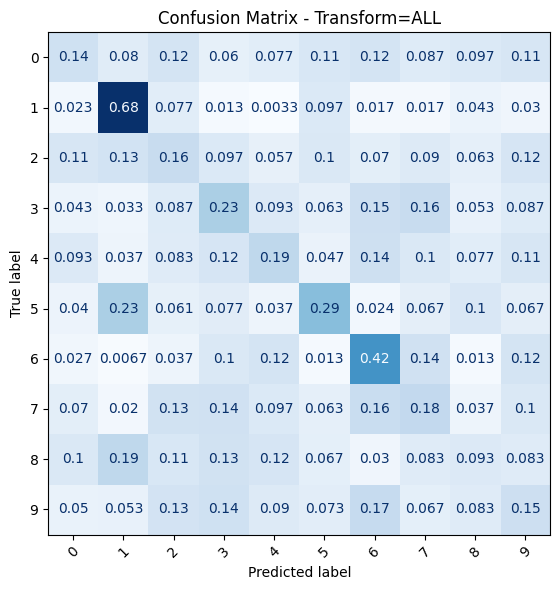

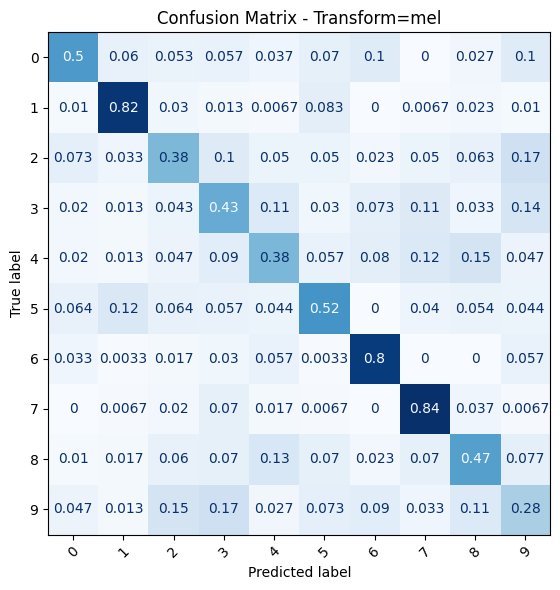

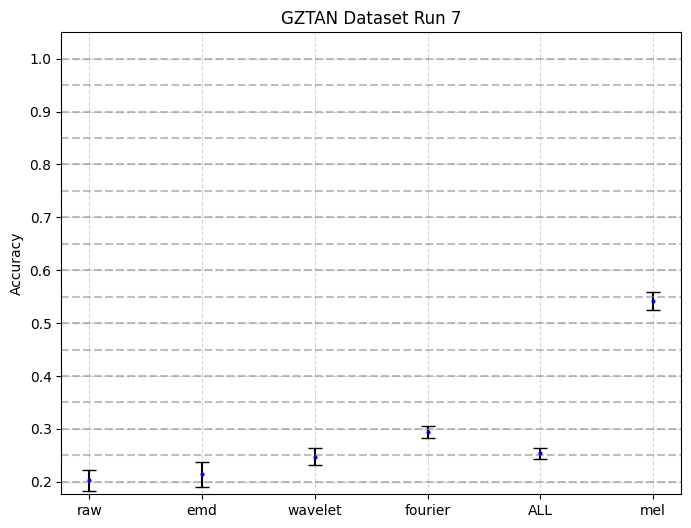

({'raw': 0.20255276560783386,
  'emd': 0.21424120763937632,
  'wavelet': 0.24758458832899727,
  'fourier': 0.2936147431532542,
  'ALL': 0.2536013384660085,
  'mel': 0.5412043591340383},
 {'raw': 0.0203057985341742,
  'emd': 0.02331184439546248,
  'wavelet': 0.015847650163466263,
  'fourier': 0.01108208397366224,
  'ALL': 0.010836703243112646,
  'mel': 0.01713204459631772})

In [30]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 7",RUN=7)

# Run 8

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 1 average test_acc over repeats: 0.2217
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 2 average test_acc over repeats: 0.1883
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 3 average test_acc over repeats: 0.1700
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.2400
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 5 average test_acc over repeats: 0.2446

Transform [raw] => 5-fold mean=0.2129, std=0.0292

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

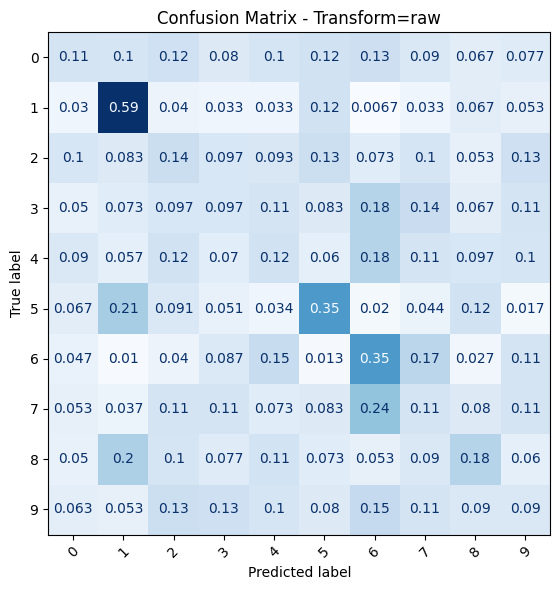

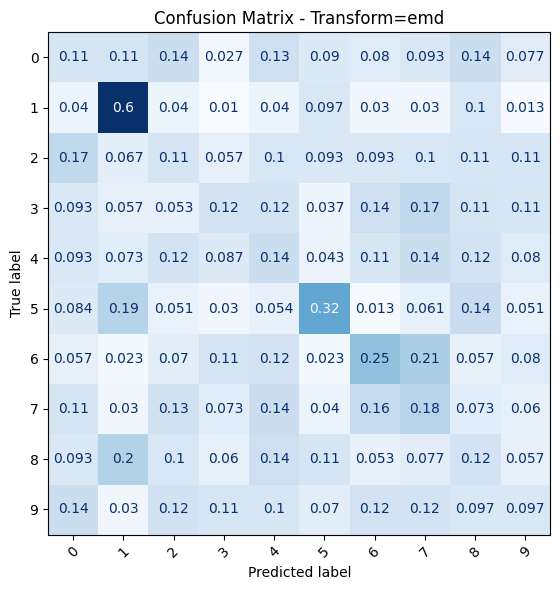

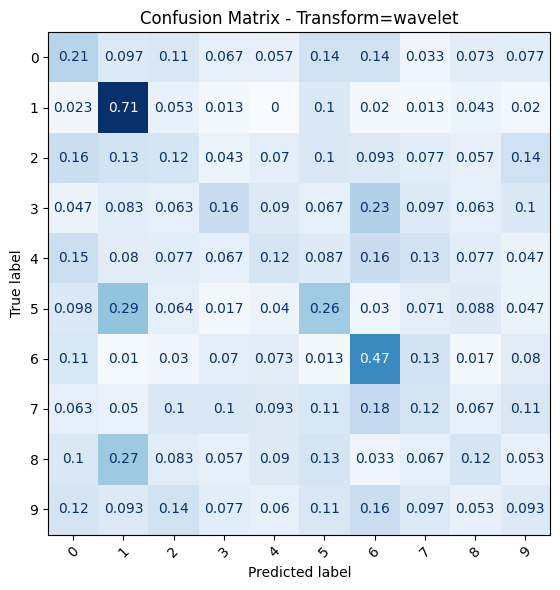

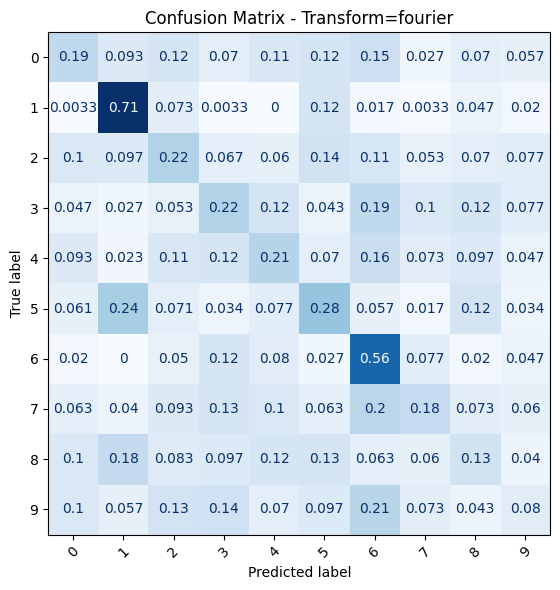

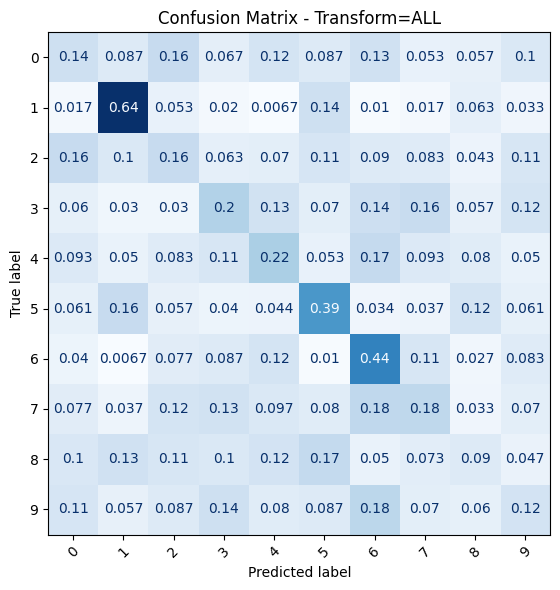

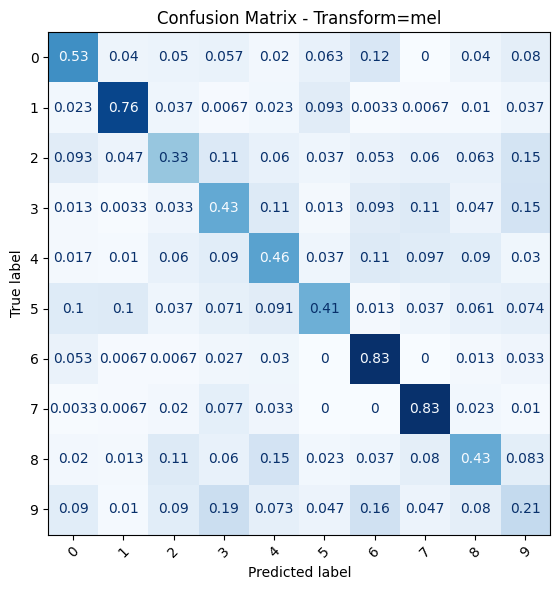

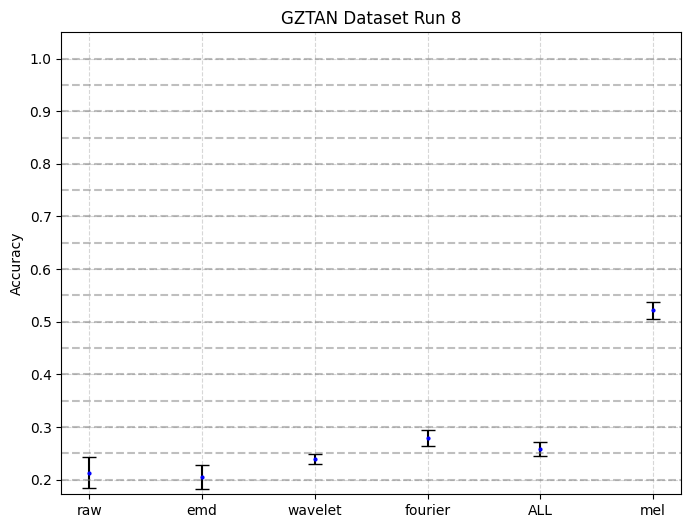

({'raw': 0.21291122237841292,
  'emd': 0.20489614804585776,
  'wavelet': 0.23890284597873687,
  'fourier': 0.27928643027941386,
  'ALL': 0.258611390988032,
  'mel': 0.5215159078439077},
 {'raw': 0.029179801635829276,
  'emd': 0.02191816781404855,
  'wavelet': 0.010222090606822701,
  'fourier': 0.015347413303929892,
  'ALL': 0.01368106031237394,
  'mel': 0.01631082556173393})

In [32]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 8",RUN=8)

# Run 9

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 1 average test_acc over repeats: 0.1833
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 2 average test_acc over repeats: 0.2217
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 3 average test_acc over repeats: 0.2117
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.1733
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 5 average test_acc over repeats: 0.1960

Transform [raw] => 5-fold mean=0.1972, std=0.0177

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

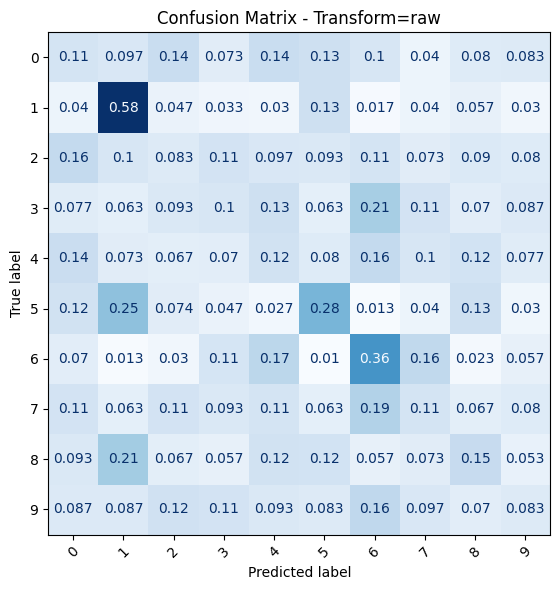

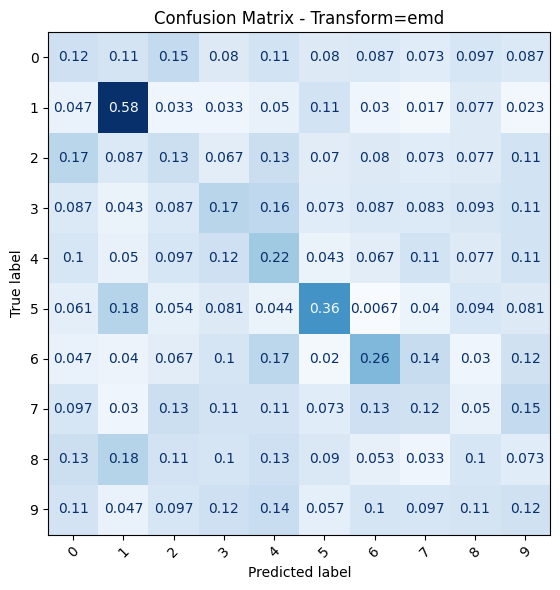

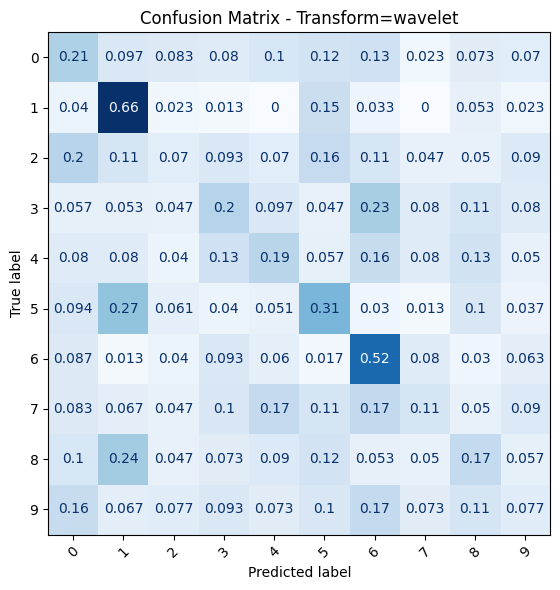

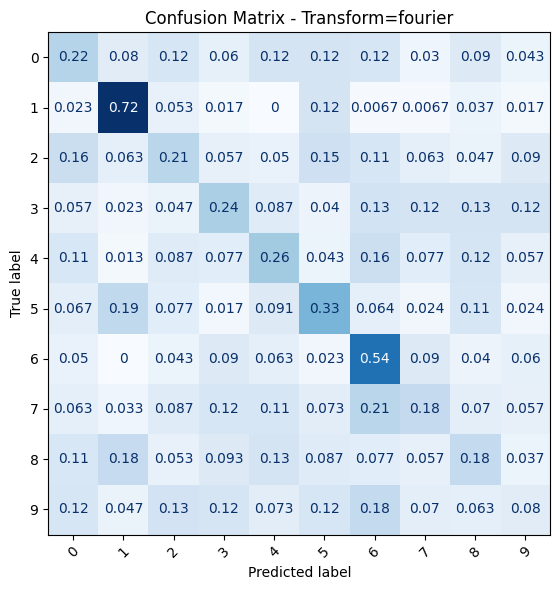

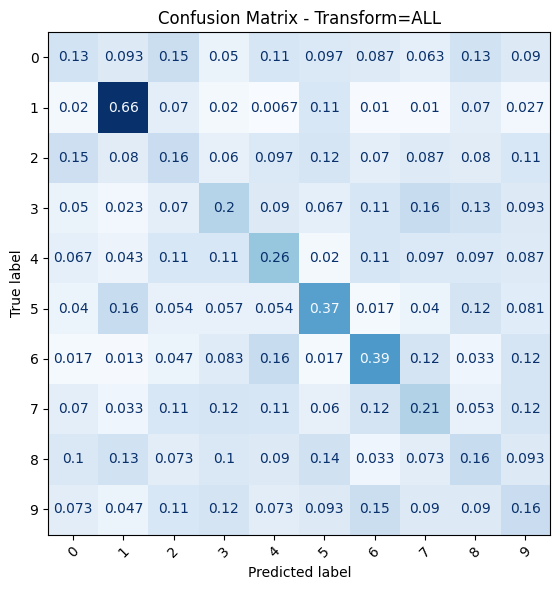

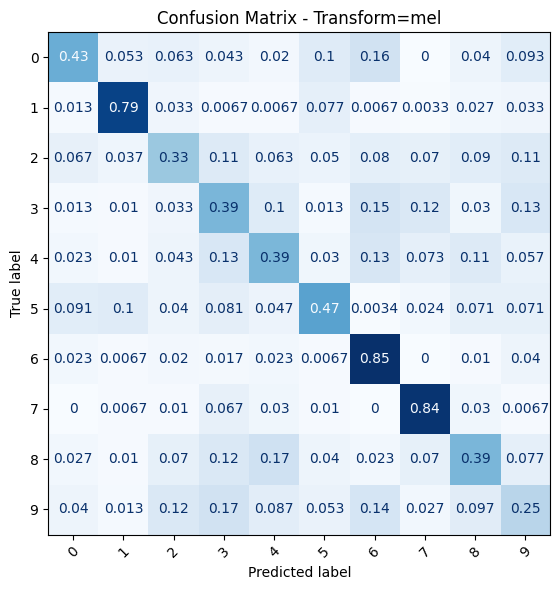

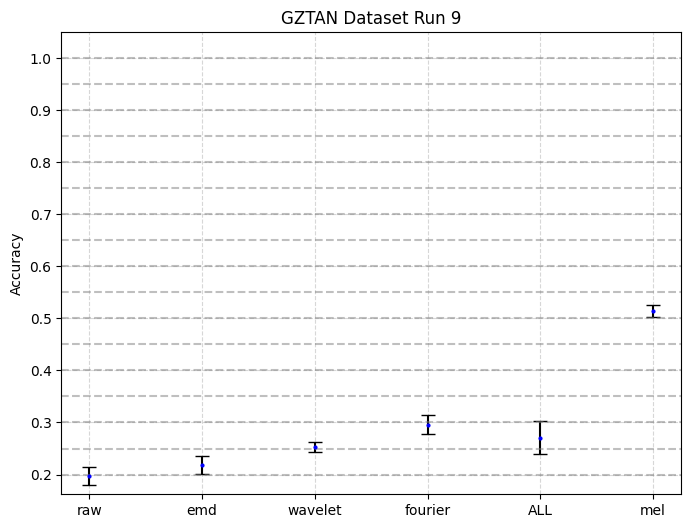

({'raw': 0.19719597995281218,
  'emd': 0.21823450426260632,
  'wavelet': 0.25225125551223754,
  'fourier': 0.2956398646036784,
  'ALL': 0.27099329829216,
  'mel': 0.5138659973939259},
 {'raw': 0.017727341959372384,
  'emd': 0.017952726763274755,
  'wavelet': 0.009816243394722582,
  'fourier': 0.017921809170878468,
  'ALL': 0.031268178547560296,
  'mel': 0.012018568926897484})

In [34]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 9",RUN=9)

# Run 10

After bandpass filtering, X_filtered shape = (999, 200)

=== Transform: raw ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 1 average test_acc over repeats: 0.1917
 Fold 2 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 2 average test_acc over repeats: 0.2183
 Fold 3 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 0s 3ms/step
 => Fold 3 average test_acc over repeats: 0.2050
 Fold 4 => train=600, val=199, test=200
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 4 average test_acc over repeats: 0.2150
 Fold 5 => train=600, val=200, test=199
(999, 200)
7/7 [==============================] - 0s 2ms/step
 => Fold 5 average test_acc over repeats: 0.2161

Transform [raw] => 5-fold mean=0.2092, std=0.0099

=== Transform: emd ===
 Fold 1 => train=599, val=200, test=200
(999, 200)
7/7 [==============================] - 

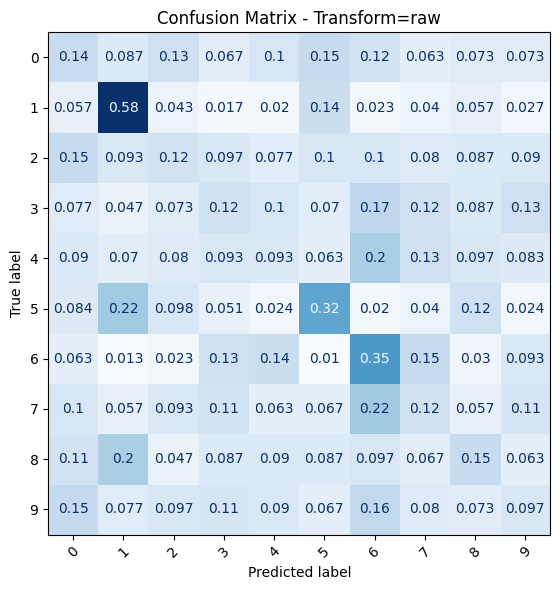

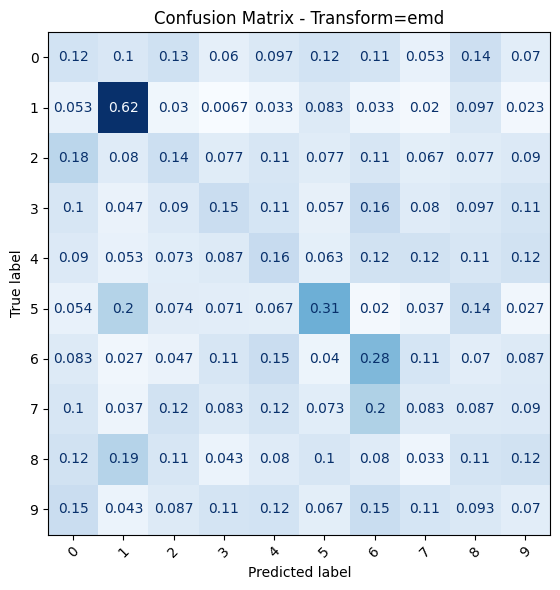

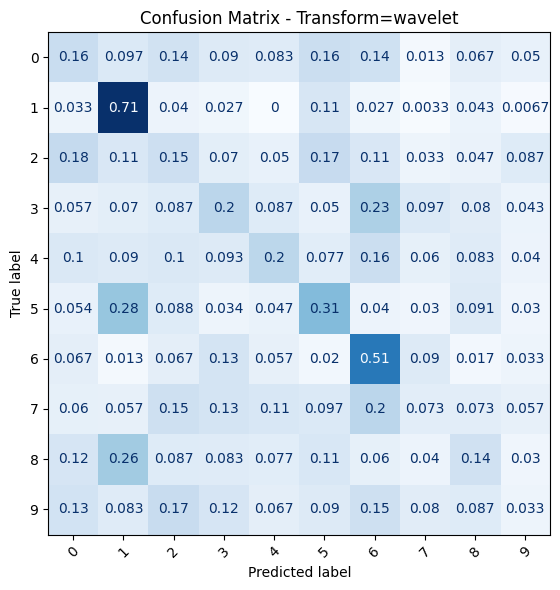

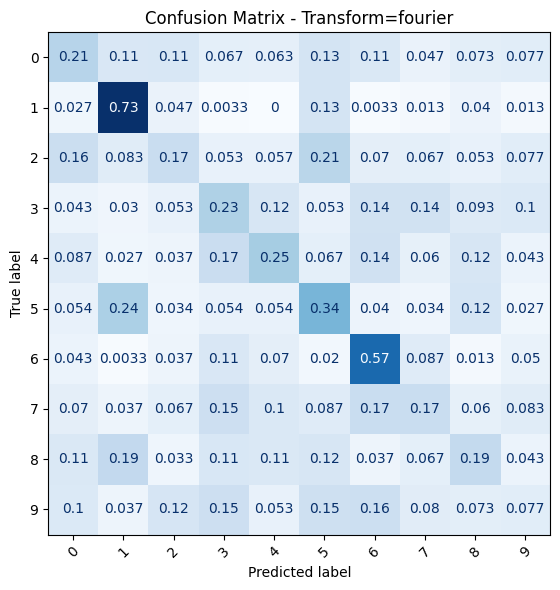

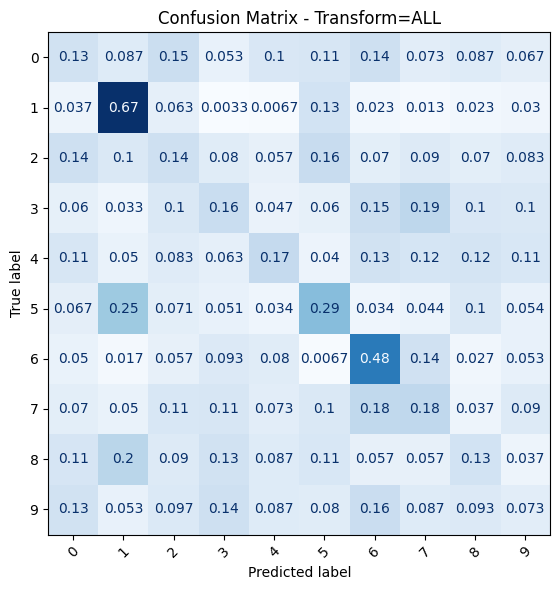

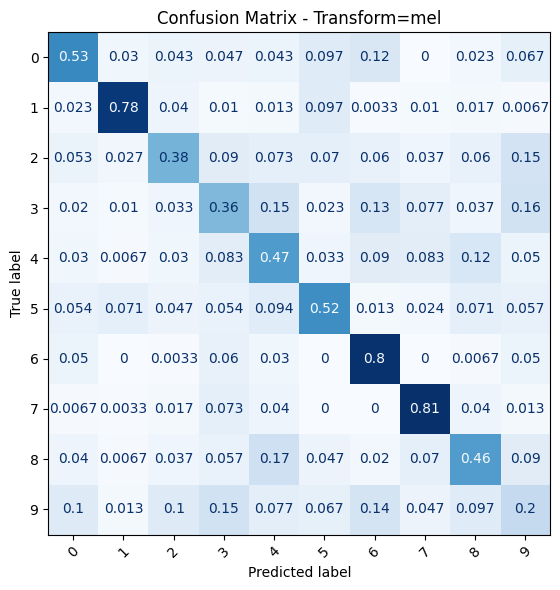

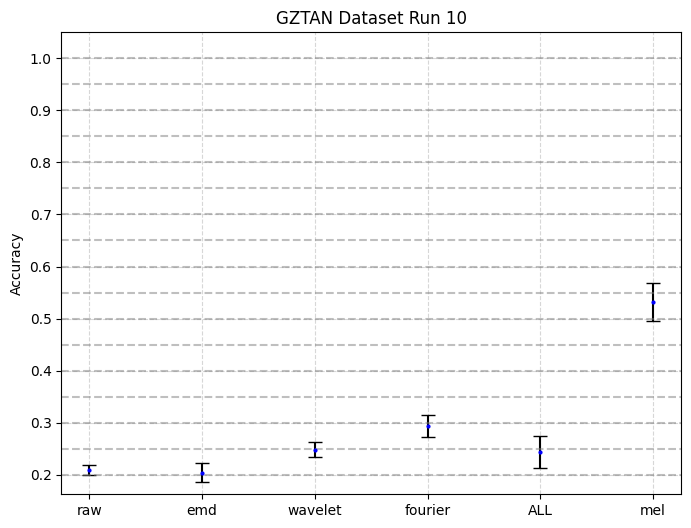

({'raw': 0.2092160771290461,
  'emd': 0.20420937836170197,
  'wavelet': 0.24822948078314466,
  'fourier': 0.29365158875783287,
  'ALL': 0.24360636572043104,
  'mel': 0.5315443893273671},
 {'raw': 0.009893981292321418,
  'emd': 0.018177852784020784,
  'wavelet': 0.01496165227618265,
  'fourier': 0.021927443612893376,
  'ALL': 0.030040584018035846,
  'mel': 0.037120217749658437})

In [36]:
CNNSignalExperiment(
    X=Xgt, y=Ygt,
    transform_options = ['raw','emd','wavelet','fourier','ALL','mel'], 
    batch_size=50,
    max_epochs=50,
    plot_title="GZTAN Dataset Run 10",RUN=10)